#####For Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install /content/gdrive/MyDrive/GC/ML_Project2/scpyro/

In [ ]:
!pip install /content/gdrive/MyDrive/GC/ML_Project2/latenta/

In [ ]:
!pip install /content/gdrive/MyDrive/GC/ML_Project2/latento/

In [6]:
import sys
sys.path.append('/content/gdrive/MyDrive/GC/ML_Project2/project-433/code')

#####Import packages

In [48]:
# autoreloading is nice so that any changes you make to the package will automatically be reloaded
# this works for all classes and functions, so if you want to debug something you can just add a print or embed and it will work!
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp

import numpyro
import numpyro.infer.autoguide
import tqdm.auto as tqdm

# the main package in which you will be working
import latento

# this is the package I am developing based on pyro
# it contains a lot of things which you won't use
# you'll only use the synthetic data generator
import latenta

# this is a biological package for plotting single-cell data
import scanpy as sc

# we use this package for some helper functions for plotting
import scpyro

# we use this module for trainining MCMC and VI
import estimate_posteriors

# we use this module to visualize posterior distributions
import plot_posteriors

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# set this to gpu if you get it to work (and if it is faster)
numpyro.set_platform('cpu')

# test gpu
key = jax.random.PRNGKey(0)

In [ ]:
# !nvidia-smi

## Biological background

Multicellular organisms are composed of cells. Cells have different functions, and this is for example reflected in differences in gene activity, also called **gene expression**, or the **transcriptome**. Genes that are more active have more "copies" present in the cell. There are now technologies that make it possible to read out the number of mRNAs inside a cell for each gene (=> count data). What we get from these technologies is a matrix with for each cell a value for each gene.

To know more: 
- https://en.wikipedia.org/wiki/Central_dogma_of_molecular_biology
- https://en.wikipedia.org/wiki/Transcriptomics_technologies
- https://en.wikipedia.org/wiki/Single-cell_transcriptomics

We are interested in how this gene expression changes dependening on the type of cell, its location in our body, or external circumstances. One way to study this is by perturbing the cell, e.g. by adding some chemicals or adding an extra gene to the cell. We often have two conditions: a control condition in which we did not perturb the cells, and a perturbed condition in which we perturbed the cells to a certain magnitude (which we know). We now want to know what this perturbation does to the cell, i.e. how it affects the transcriptome. There are many models to make here, some including latent variables, but here we'll focus on generalized linear models, in which the expression of each gene depends on the magnitude of perturbation in some linear or non-linear way. A gene can respond in different ways to this: it can increase linearly with the magnitude of a perturbation, it can suddenly jump up or down once the perturbation reaches a certain threshold, it can do nothing, ... 

The goal is to use Bayesian modelling to select appropriate models for each gene, and to know how uncertain we are. If we are too uncertain, it may we worthwhile to get more samples (i.e. cells) so that we can get a better model.

Bayesian modelling can however be quite slow, especially because we're working with a lot of cells (>10k) and a lot of genes (5-20k). I'm therefore using approximate Bayesian techniques called variational inference. But I do not know whether these approximations are correct. The goal of this project is to compare variational inference posteriors with exact posteriors derived from MCMC.

## Generate the dataset

In [20]:
# the structure of the toy dataset
config = {
    "id":"toy",
    "n_cells":400,
    "modules":[
        {"id":"add_uniform_perturbation"}, # adds a perturbation to each cell
        {"id":"add_perturbation_switch"}, # adds a global switch point
        {"id":"add_nothing", "n":10}, # adds n genes that stay the same in all cells
        {"id":"add_perturbed_linear", "n":10}, # adds n genes of which the expression changes linearly with the perturbation
        {"id":"add_perturbed_switch", "n":10} # adds n genes of which the expression changes at the switch point
    ]
}

In [21]:
dir = '/content/gdrive/MyDrive/GC/ML_Project2/project-433'

# create dataset
# dataset = estimate_posteriors.create_dataset(config)

# or save dataset as pickle
# estimate_posteriors.save_pickle(dataset, f'{dir}/data/dataset_pkl.pkl')

# or load dataset from pickle
dataset = estimate_posteriors.load_pickle(f'{dir}/data/dataset_pkl.pkl')

In [22]:
# dataset.obs contains info on cells
dataset.obs

,cell_ix,cell,library,x_perturb,x_perturb_log
cell,,,,,
cell_0,0,cell_0,150,0.000000,0.000000
cell_1,1,cell_1,150,0.000000,0.000000
cell_2,2,cell_2,150,0.000000,0.000000
cell_3,3,cell_3,150,21.633927,3.119450
cell_4,4,cell_4,150,0.000000,0.000000
...,...,...,...,...,...
cell_395,395,cell_395,150,0.000000,0.000000
cell_396,396,cell_396,150,0.000000,0.000000
cell_397,397,cell_397,150,1263.475885,7.142413


In [23]:
# dataset.var contains info on genes
# the type is important, we chose this in the config
dataset.var

,gene,gene_ix,type,dispersion,structure_id,extra,symbol
gene,,,,,,,
nothing_1,nothing_1,0,nothing,0.5,NaN,{'rho_0': 41.7022004702574},nothing_1
nothing_2,nothing_2,1,nothing,0.5,NaN,{'rho_0': 43.59949021420037},nothing_2
nothing_3,nothing_3,2,nothing,0.5,NaN,{'rho_0': 55.07979025745755},nothing_3
nothing_4,nothing_4,3,nothing,0.5,NaN,{'rho_0': 96.70298390136767},nothing_4
nothing_5,nothing_5,4,nothing,0.5,NaN,{'rho_0': 22.199317108973947},nothing_5
nothing_6,nothing_6,5,nothing,0.5,NaN,{'rho_0': 89.28601514360017},nothing_6
nothing_7,nothing_7,6,nothing,0.5,NaN,{'rho_0': 7.630828937395718},nothing_7
nothing_8,nothing_8,7,nothing,0.5,NaN,{'rho_0': 87.34294027918162},nothing_8
nothing_9,nothing_9,8,nothing,0.5,NaN,{'rho_0': 1.0374153885699955},nothing_9


In [24]:
# dataset.counts contains the raw counts
dataset.counts

gene,nothing_1,nothing_2,nothing_3,nothing_4,nothing_5,nothing_6,nothing_7,nothing_8,nothing_9,nothing_10,x_linear_up_11,x_linear_up_12,x_linear_up_13,x_linear_down_14,x_linear_down_15,x_linear_up_16,x_linear_down_17,x_linear_up_18,x_linear_down_19,x_linear_up_20,switch_down_21,switch_down_22,switch_up_23,switch_down_24,switch_down_25,switch_up_26,switch_down_27,switch_down_28,switch_up_29,switch_up_30
cell,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cell_0,15.0,0.0,2.0,1.0,0.0,12.0,0.0,25.0,0.0,14.0,0.0,0.0,1.0,24.0,2.0,0.0,7.0,0.0,1.0,0.0,4.0,5.0,0.0,5.0,21.0,0.0,14.0,42.0,0.0,0.0
cell_1,10.0,3.0,4.0,32.0,7.0,29.0,4.0,17.0,1.0,15.0,0.0,0.0,1.0,4.0,3.0,0.0,7.0,0.0,24.0,0.0,0.0,11.0,0.0,3.0,4.0,0.0,4.0,7.0,0.0,0.0
cell_2,11.0,9.0,9.0,11.0,0.0,15.0,0.0,33.0,0.0,27.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0,1.0,6.0,0.0,0.0,5.0,19.0,0.0,0.0
cell_3,5.0,7.0,3.0,31.0,1.0,7.0,0.0,0.0,0.0,7.0,0.0,2.0,2.0,5.0,2.0,2.0,5.0,3.0,9.0,6.0,8.0,16.0,0.0,20.0,7.0,0.0,7.0,13.0,0.0,1.0
cell_4,6.0,6.0,0.0,3.0,2.0,7.0,1.0,10.0,0.0,55.0,0.0,0.0,0.0,6.0,7.0,0.0,2.0,0.0,10.0,0.0,7.0,3.0,0.0,4.0,0.0,0.0,15.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_395,5.0,13.0,0.0,11.0,1.0,5.0,3.0,32.0,0.0,10.0,0.0,0.0,0.0,34.0,1.0,0.0,10.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,6.0,0.0,12.0,10.0,0.0,0.0
cell_396,5.0,14.0,11.0,5.0,3.0,10.0,5.0,18.0,0.0,1.0,1.0,0.0,0.0,12.0,0.0,0.0,23.0,0.0,12.0,0.0,0.0,2.0,0.0,22.0,3.0,0.0,11.0,5.0,2.0,1.0
cell_397,0.0,5.0,14.0,6.0,1.0,15.0,0.0,32.0,0.0,12.0,4.0,1.0,7.0,2.0,2.0,3.0,1.0,1.0,2.0,11.0,0.0,0.0,8.0,0.0,0.0,16.0,0.0,0.0,0.0,1.0


In [25]:
# choose some genes for plotting, each with a different "type"
gene_ids = dataset.var.groupby("type").sample(n=1, random_state=3)["gene"]

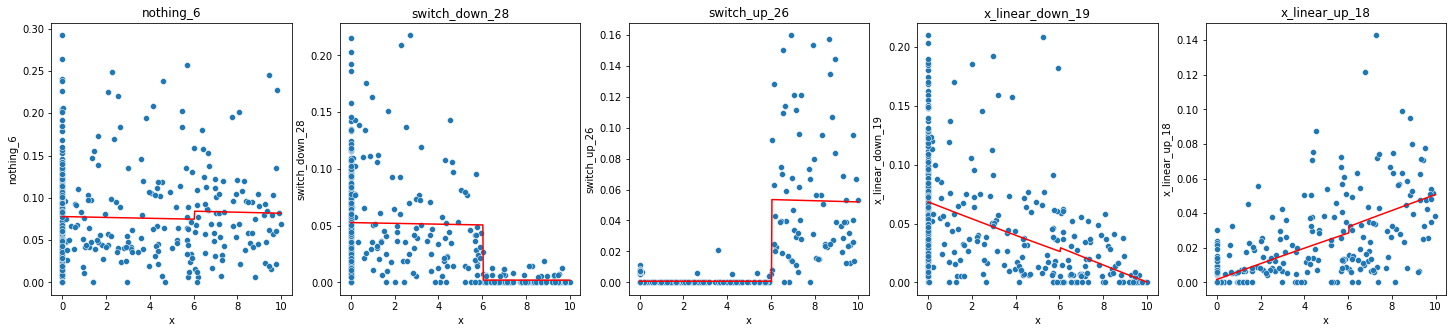

In [26]:
# let's plot some genes
# biologists are not interested in the number of counts in a cell, but rather it's normalized value: the percentage of counts in a cell that comes from a certain gene
# we give this value the greek symrbol "rho"
# because we're currently using synthetic data, we know the ground truth rho
# what we observe is a very noise value of this for each cell and gene

toy = latenta.toy.wrap.cases.get_case(config)

# select a couple of genes of interest, for each "type"
perturb_id = toy.perturb.var.index[0]

fig, axes = scpyro.plotting.axes_wrap(len(gene_ids))
for gene, ax in zip(gene_ids, axes):
    x = np.log(dataset.perturb.X[perturb_id] + 1)
    sns.scatterplot(x = x, y = dataset.rho[gene], ax = ax)
    sns.lineplot(x = x, y = dataset["rho"][gene], ax = ax, color = "red") # gold standard rho
    ax.set_title(gene)

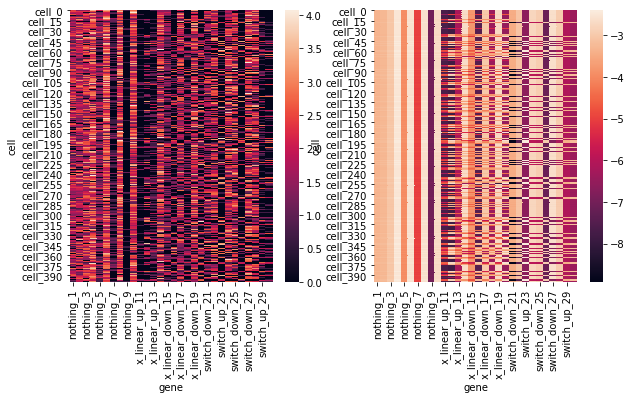

In [27]:
# this is how the gene expression looks like: cells vs genes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
sns.heatmap(np.log(dataset.counts + 1), ax = ax1) # this is the gene expression as we observe it, i.e. counts. For visualization we often calculate a log(x+1)
sns.heatmap(np.log(dataset["rho"]), ax = ax2) # this is the gold standard "rho" = the fraction that comes from a certain gene. This is what we're mainly interested in

... storing 'type' as categorical


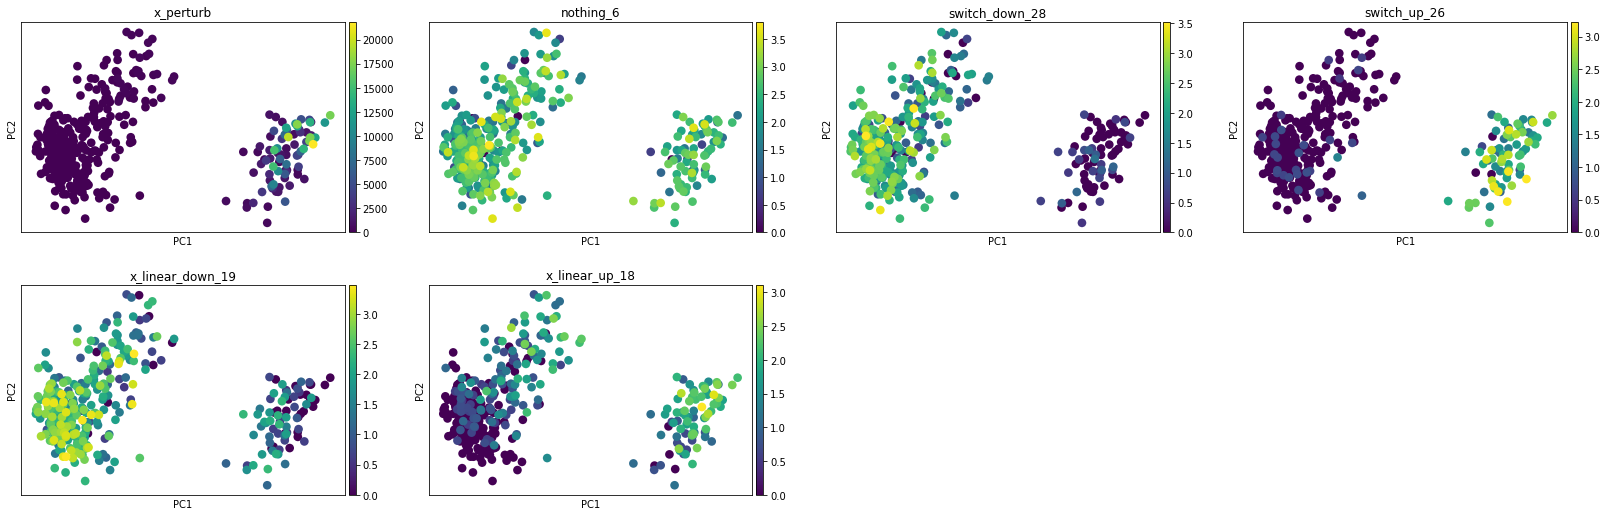

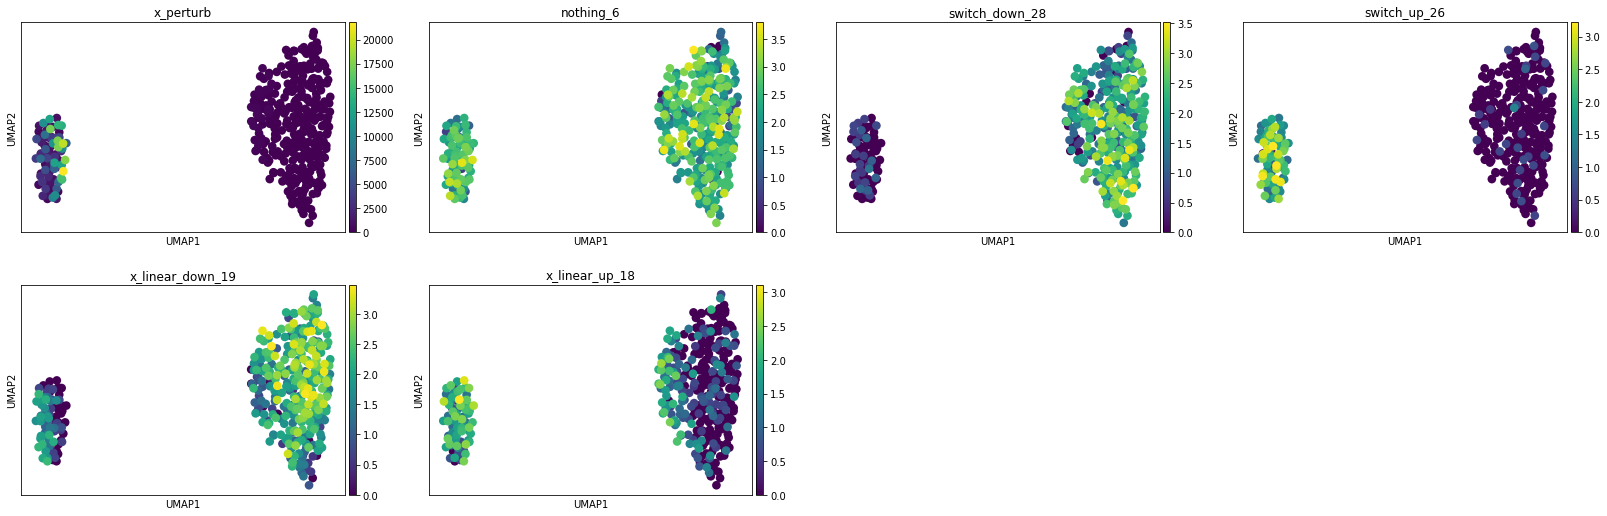

In [28]:
# single-cell data is often plotted on a pca or umap (non-linear dimensionality reduction)
# we can then plot the perturbation (x_perturb) or the gene expression (e.g. linear_down_19) on this (again often log(x+1) transformed)
# we'll use the scanpy package for this plotting
# you can access this dimensionality reduction using dataset.adata.obsm["X_pca"] or dataset.adata.obsm["X_umap"]
sc.tl.umap(dataset.adata)
sc.pl.pca(dataset.adata, color = ["x_perturb"] + gene_ids.tolist()) # pca
sc.pl.umap(dataset.adata, color = ["x_perturb"] + gene_ids.tolist()) # umap

## Define the model

In [29]:
# define the model
model = latento.models.ModelNothing(dataset)

# transform dataset to log and scale to max
infer_args = estimate_posteriors.transform_dataset(dataset)

# generate key for training and prediction
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

**Your tasks**

Implement a "switch"-like model, i.e. where the gene expression jumps up or down (=beta) at a particular perturbation value (=switch). 

Because this function is not smooth at p = switch, it can be hard to train using gradient-based optimizers. We therefore approximate the switch model using a "relaxation"* : $$deviation = beta \dfrac{1}{1 + e^{-skew*(p - switch)}}$$ beta and switch are random variables, skew is a fixed value that we choose ourselves and defines the extent of "relaxation", I often choose 50

If there is time left, you can try to implement other models, e.g. an exponential model, or a spline model. But only if there is time left!

*: https://en.wikipedia.org/wiki/Relaxation_(approximation)

## MCMC

MCMC sampling using a NUTS sampler

A nice explanation on how MCMC (and sampling in general) allows you to get an "exact" posterior: https://bjlkeng.github.io/posts/markov-chain-monte-carlo-mcmc-and-the-metropolis-hastings-algorithm/

In [ ]:
# train MCMC
num_warmup = 200 #1000
num_samples = 200 #2000

mcmc = estimate_posteriors.train_mcmc(model, infer_args, rng_key, num_warmup, num_samples)

# some statistics of the posterior, the r_hat is a statistic of "convergence" for a particular random variable, this should be close to 1
mcmc.print_summary()

# get the samples from the posterior
samples_mcmc = estimate_posteriors.sample_mcmc(model, mcmc)

## Black-box variational inference

In variational inference we approximate the posterior using a variational distribution

As wikipedia explains (https://www.wikiwand.com/en/Variational_Bayesian_methods):

> For many applications, variational Bayes produces solutions of comparable accuracy to Gibbs sampling at greater speed. However, deriving the set of equations used to update the parameters iteratively often requires a large amount of work compared with deriving the comparable Gibbs sampling equations. This is the case even for many models that are conceptually quite simple, as is demonstrated below in the case of a basic non-hierarchical model with only two parameters and no latent variables.

BUT, in black-box variational inference, this "set of equations used to update the paramters" is derived computationally using automatic differentiation (i.e. using autograd or jax). This is implemented in numpyro (or pyro). Check out this talk for an explanation by the inventor himself: https://www.youtube.com/watch?v=-H2N4tVDK7I

However, this does not mean that our approximation of the posterior is good. Often the variance is underestimated, but the mean of the posterior can also be off. This is really bad as it can lead to wrong biological conclusions. See this talk: https://www.youtube.com/watch?v=Moo4-KR5qNg

In [ ]:
step_size = 0.01
n_iterations = 200 #4000

guide, svi, current_state, losses = estimate_posteriors.train_vi(model, infer_args, rng_key, step_size, n_iterations)

sns.lineplot(x = range(len(losses)), y = losses)

samples_vi = estimate_posteriors.sample_vi(model, guide, svi, current_state, num_samples)

## Compare MCMC and VI

### Comparing posterior distributions of individual or pairs of parameters

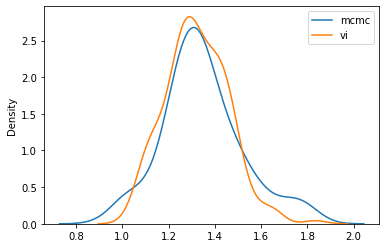

In [24]:
# compare distributions for one variable and one gene between MCMC and VI
# choose a gene
gene_ix = 14

# choose some samples, e.g. the dispersion and the 
samples_mcmc_1 = samples_mcmc["transcriptome/dispersion"][:, gene_ix]
samples_vi_1 = samples_vi["transcriptome/dispersion"][:, gene_ix]

samples_mcmc_2 = samples_mcmc["transcriptome/freq"][:, gene_ix]
samples_vi_2 = samples_vi["transcriptome/freq"][:, gene_ix]

# compare a single variable
sns.kdeplot(samples_mcmc_1, label = "mcmc")
sns.kdeplot(samples_vi_1, label = "vi")
plt.legend()

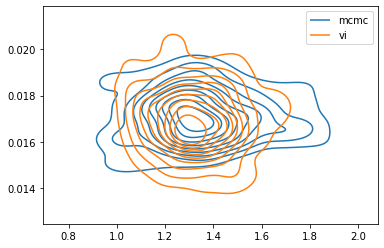

In [25]:
# compare two variables, e.g. to check dependencies
sns.kdeplot(samples_mcmc_1, samples_mcmc_2, label = "mcmc")
sns.kdeplot(samples_vi_1, samples_vi_2, label = "vi")
plt.legend()

sample: 100%|██████████| 3000/3000 [00:56<00:00, 53.37it/s, 7 steps of size 5.00e-01. acc. prob=0.86]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 transcriptome/dispersion[0]      2.32      0.24      2.31      1.92      2.72   3641.36      1.00
 transcriptome/dispersion[1]      2.17      0.21      2.15      1.82      2.51   3020.47      1.00
 transcriptome/dispersion[2]      1.79      0.16      1.78      1.54      2.08   2741.46      1.00
 transcriptome/dispersion[3]      1.88      0.15      1.87      1.63      2.12   3118.77      1.00
 transcriptome/dispersion[4]      1.89      0.24      1.87      1.51      2.28   3524.46      1.00
 transcriptome/dispersion[5]      2.39      0.21      2.39      2.05      2.73   3284.16      1.00
 transcriptome/dispersion[6]      1.32      0.24      1.29      0.97      1.71   2322.44      1.00
 transcriptome/dispersion[7]      2.06      0.17      2.05      1.77      2.32   3110.92      1.00
 transcriptome/dispersion[8]      0.94      0.40      0.86      0.35      1.46   2165.81      1.00
 transcri

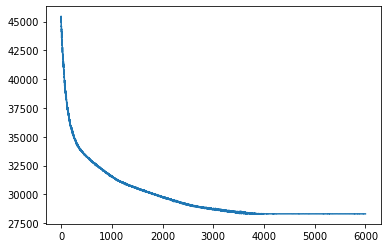

In [53]:
# 1. ----->Train and sample MCMC and VI for the Nothing model
model_nothing = latento.models.ModelNothing(dataset)

# Train and sample MCMC
num_warmup = 1000 #1000
num_samples = 2000 #2000
samples_mcmc_nothing = estimate_posteriors.train_sample_mcmc(model_nothing, infer_args, rng_key, num_warmup, num_samples)
# save samples_mcmc_nothing as pickle
# estimate_posteriors.save_pickle(samples_mcmc_nothing, f'{dir}/data/samples_mcmc_nothing.pkl')

# Train and sample VI
step_size = 0.01
n_iterations = 6000  #6000
samples_vi_nothing = estimate_posteriors.train_sample_vi(model_nothing, infer_args, rng_key, step_size, n_iterations, num_samples)
# save samples_vi_nothing as pickle
# estimate_posteriors.save_pickle(samples_vi_nothing, f'{dir}/data/samples_vi_nothing.pkl')

sample: 100%|██████████| 3000/3000 [02:46<00:00, 18.01it/s, 15 steps of size 2.71e-01. acc. prob=0.88]



                                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   transcriptome/dispersion[0]      2.36      0.26      2.35      1.95      2.77   3304.22      1.00
   transcriptome/dispersion[1]      2.19      0.22      2.18      1.84      2.54   2997.99      1.00
   transcriptome/dispersion[2]      1.80      0.16      1.80      1.55      2.08   3113.67      1.00
   transcriptome/dispersion[3]      1.87      0.16      1.86      1.61      2.15   3399.84      1.00
   transcriptome/dispersion[4]      1.88      0.25      1.86      1.49      2.29   2846.37      1.00
   transcriptome/dispersion[5]      2.39      0.21      2.38      2.05      2.73   3064.81      1.00
   transcriptome/dispersion[6]      1.31      0.25      1.28      0.89      1.67   3081.72      1.00
   transcriptome/dispersion[7]      2.07      0.18      2.07      1.81      2.38   3512.40      1.00
   transcriptome/dispersion[8]      0.91      0.37      0.84      0.36      1.40   2633.84

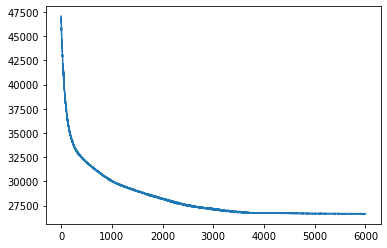

In [63]:
# 2. ----->Train and sample MCMC and VI for the Linear model
model_linear = latento.models.ModelLinear(dataset)

# Train and sample MCMC
num_warmup = 1000 #1000
num_samples = 2000 #2000
samples_mcmc_linear = estimate_posteriors.train_sample_mcmc(model_linear, infer_args, rng_key, num_warmup, num_samples)
# save samples_mcmc_linear as pickle
# estimate_posteriors.save_pickle(samples_mcmc_linear, f'{dir}/data/samples_mcmc_linear.pkl')

# Train and sample VI
step_size = 0.01
n_iterations = 6000  #4000
samples_vi_linear = estimate_posteriors.train_sample_vi(model_linear, infer_args, rng_key, step_size, n_iterations, num_samples)
# save samples_vi_linear as pickle
# estimate_posteriors.save_pickle(samples_vi_linear, f'{dir}/data/samples_vi_linear.pkl')

sample: 100%|██████████| 3500/3500 [1:32:55<00:00,  1.59s/it, 1023 steps of size 4.04e-03. acc. prob=0.80]



                                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   transcriptome/dispersion[0]      2.35      0.26      2.34      1.98      2.80   1952.75      1.00
   transcriptome/dispersion[1]      2.20      0.23      2.18      1.84      2.56   2388.72      1.00
   transcriptome/dispersion[2]      1.81      0.18      1.80      1.53      2.12   1798.87      1.00
   transcriptome/dispersion[3]      1.87      0.15      1.86      1.62      2.11   2264.57      1.00
   transcriptome/dispersion[4]      1.88      0.23      1.85      1.53      2.25   2101.84      1.00
   transcriptome/dispersion[5]      2.39      0.21      2.38      2.05      2.72   2184.64      1.00
   transcriptome/dispersion[6]      1.30      0.25      1.27      0.90      1.66   2206.44      1.00
   transcriptome/dispersion[7]      2.07      0.18      2.07      1.78      2.37   2442.67      1.00
   transcriptome/dispersion[8]      0.95      0.38      0.87      0.41      1.50   1825.04

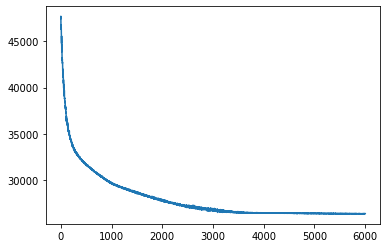

In [65]:
# 3. ----->Train and sample MCMC and VI for the Switch model
model_switch = latento.models.ModelSwitch(dataset)

# Train and sample MCMC
num_warmup = 1500 #1000
num_samples = 2000 #2000
samples_mcmc_switch = estimate_posteriors.train_sample_mcmc(model_switch, infer_args, rng_key, num_warmup, num_samples)
# save samples_mcmc_switch as pickle
# estimate_posteriors.save_pickle(samples_mcmc_switch, f'{dir}/data/samples_mcmc_switch.pkl')

# Train and sample VI
step_size = 0.01
n_iterations = 6000  #4000
samples_vi_switch = estimate_posteriors.train_sample_vi(model_switch, infer_args, rng_key, step_size, n_iterations, num_samples)
# save samples_vi_switch as pickle
# estimate_posteriors.save_pickle(samples_vi_switch, f'{dir}/data/samples_vi_switch.pkl')

In [30]:
# load samples from pickle objects
samples_mcmc_nothing = estimate_posteriors.load_pickle(f'{dir}/data/samples_mcmc_nothing.pkl')
samples_mcmc_linear = estimate_posteriors.load_pickle(f'{dir}/data/samples_mcmc_linear.pkl')
samples_mcmc_switch = estimate_posteriors.load_pickle(f'{dir}/data/samples_mcmc_switch.pkl')

samples_vi_nothing = estimate_posteriors.load_pickle(f'{dir}/data/samples_vi_nothing.pkl')
samples_vi_linear = estimate_posteriors.load_pickle(f'{dir}/data/samples_vi_linear.pkl')
samples_vi_switch = estimate_posteriors.load_pickle(f'{dir}/data/samples_vi_switch.pkl')

In [31]:
# Define parameters for the generation of set1 figures
save_path = f'{dir}/figures/set1'

dist_type = [['dispersion', 'freq'],
             ['dispersion', 'freq', 'perturb/beta'],
             ['dispersion', 'freq', 'perturb/beta', 'switch']]

model_name = ['Nothing model', 'Linear model', 'Switch model']

samples_mcmc = [samples_mcmc_nothing, samples_mcmc_linear, samples_mcmc_switch]
samples_vi = [samples_vi_nothing, samples_vi_linear, samples_vi_switch]

In [67]:
# SET 1 figures: Plot figures for one variable

for zip_ in zip(dist_type, model_name, samples_mcmc, samples_vi):
  dist_type_, model_name_, samples_mcmc_, samples_vi_ = zip_[0], zip_[1], zip_[2], zip_[3]
  for dist in dist_type_:
    plot_posteriors.print_MCMC_VI_single_variable(dist, model_name_, samples_mcmc_, samples_vi_, dataset, save_path)

Output hidden; open in https://colab.research.google.com to view.

In [68]:
# SET 1 figures: Plot figures for two variables

for zip_ in zip(dist_type, model_name, samples_mcmc, samples_vi):
  dist_type_, model_name_, samples_mcmc_, samples_vi_ = zip_[0], zip_[1], zip_[2], zip_[3]
  for index_1, dist_1 in enumerate(dist_type_):
    for index_2, dist_2 in enumerate(dist_type_):
      if index_2 > index_1:
        plot_posteriors.print_MCMC_VI_two_variables(dist_1, dist_2, model_name_, samples_mcmc_, samples_vi_, dataset, save_path)

Output hidden; open in https://colab.research.google.com to view.

Figure saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/figures/set1/Nothing model/Nothing model_rho_estimation.jpg
Figure saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/figures/set1/Linear model/Linear model_rho_estimation.jpg
Figure saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/figures/set1/Switch model/Switch model_rho_estimation.jpg


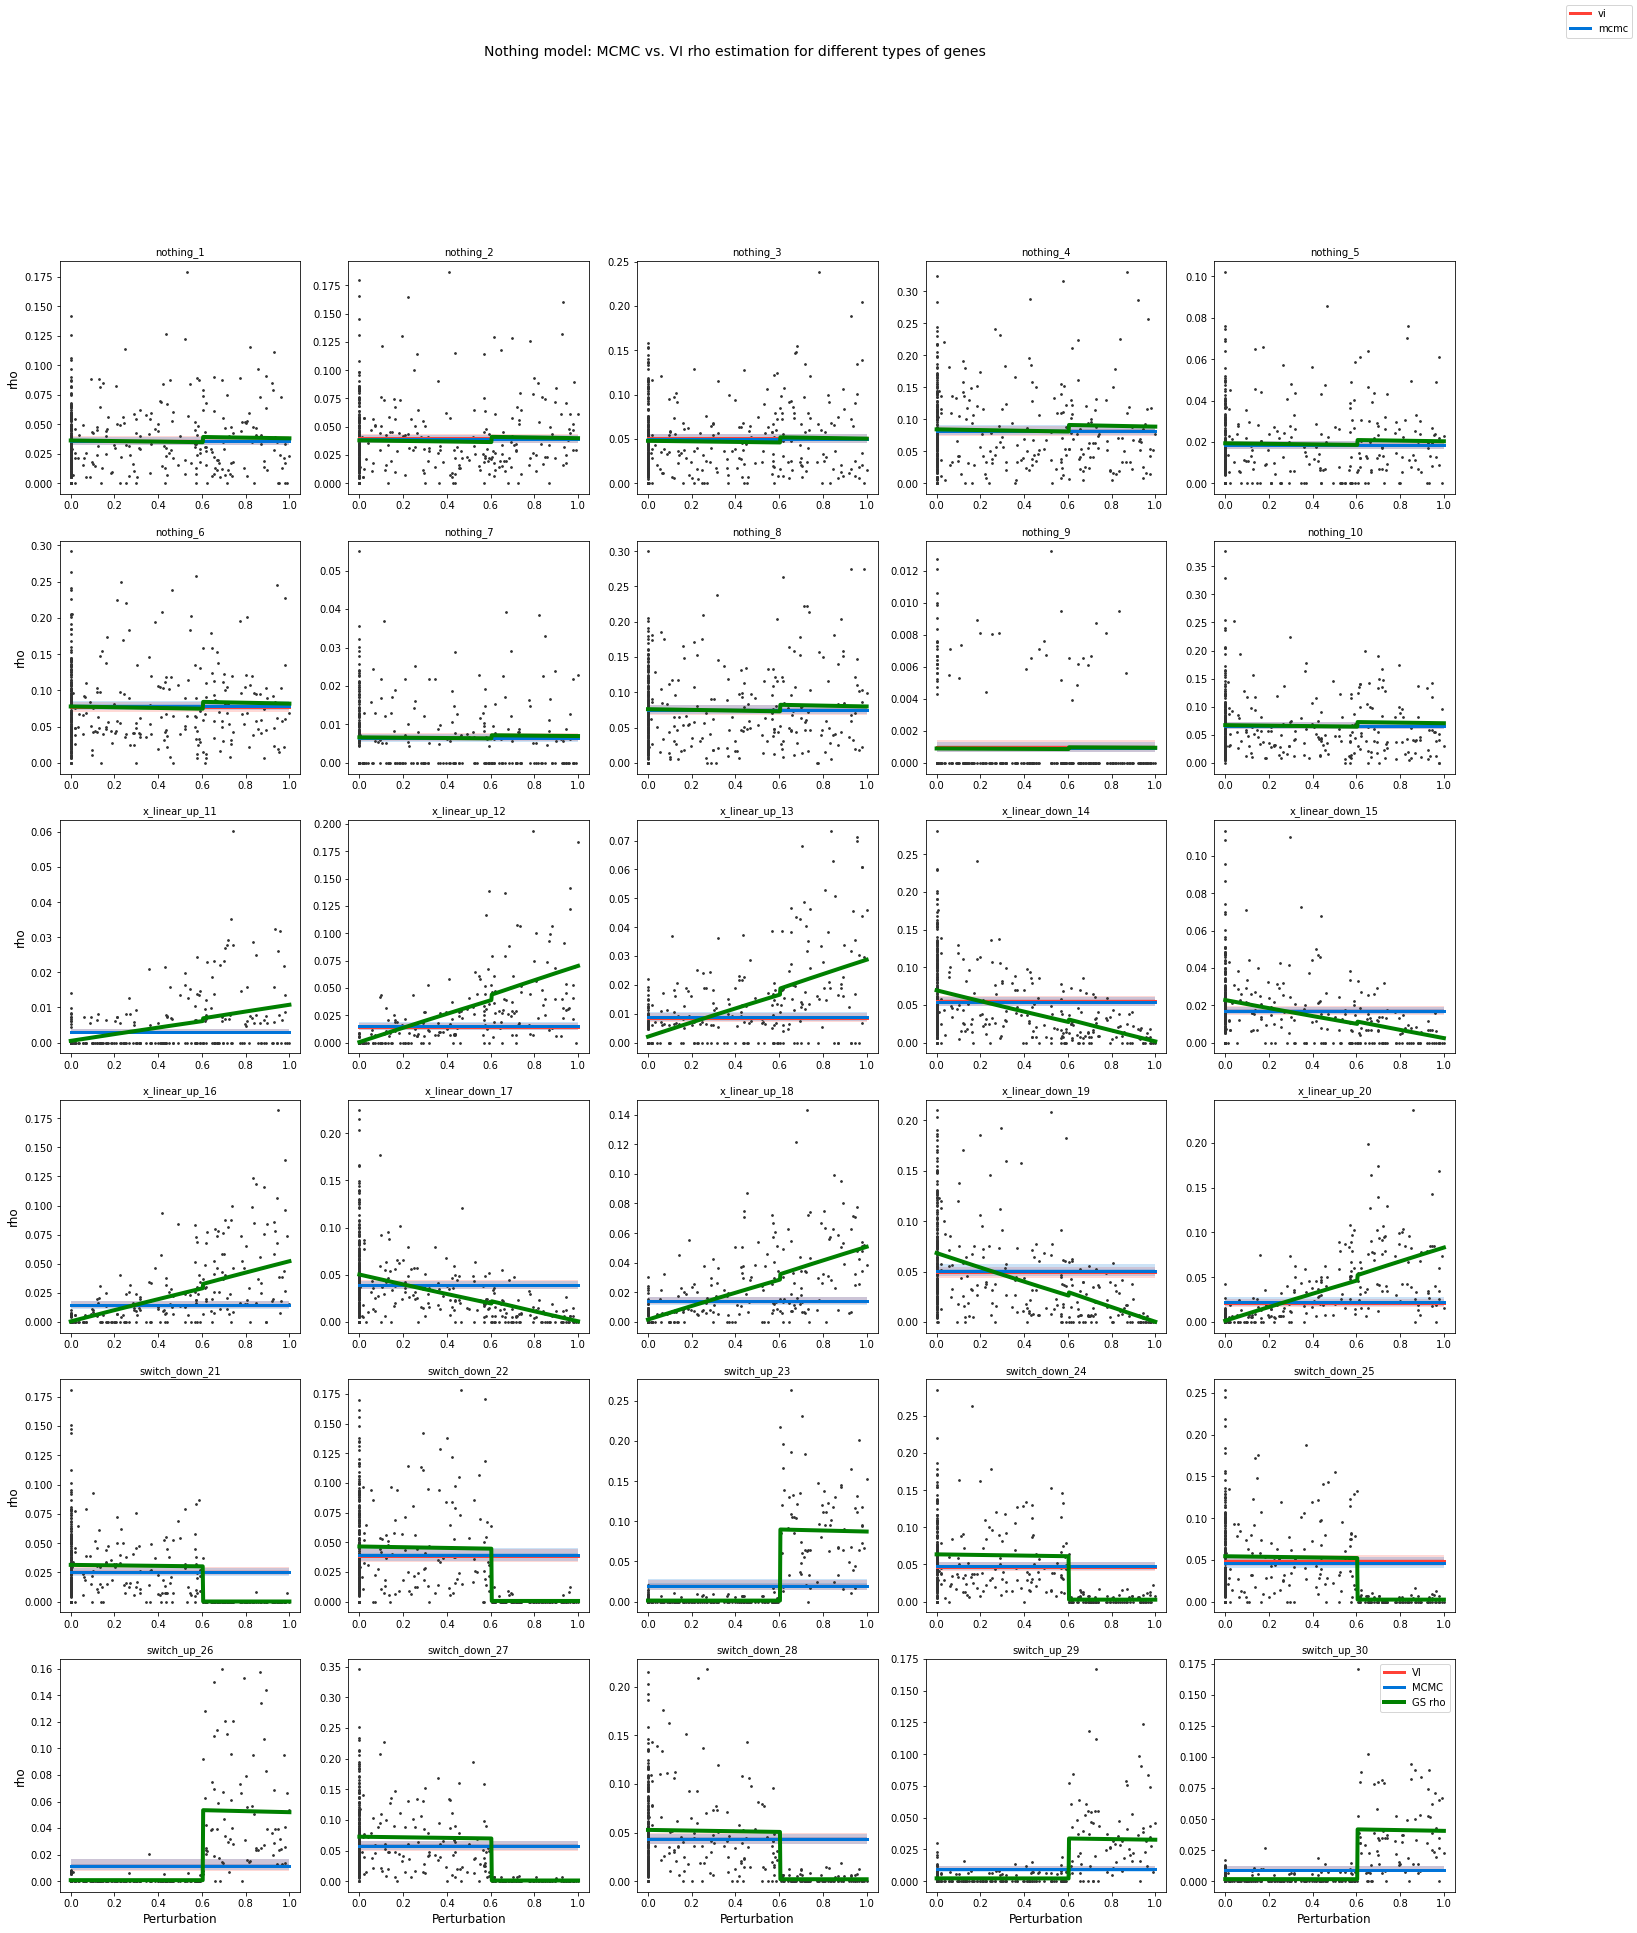

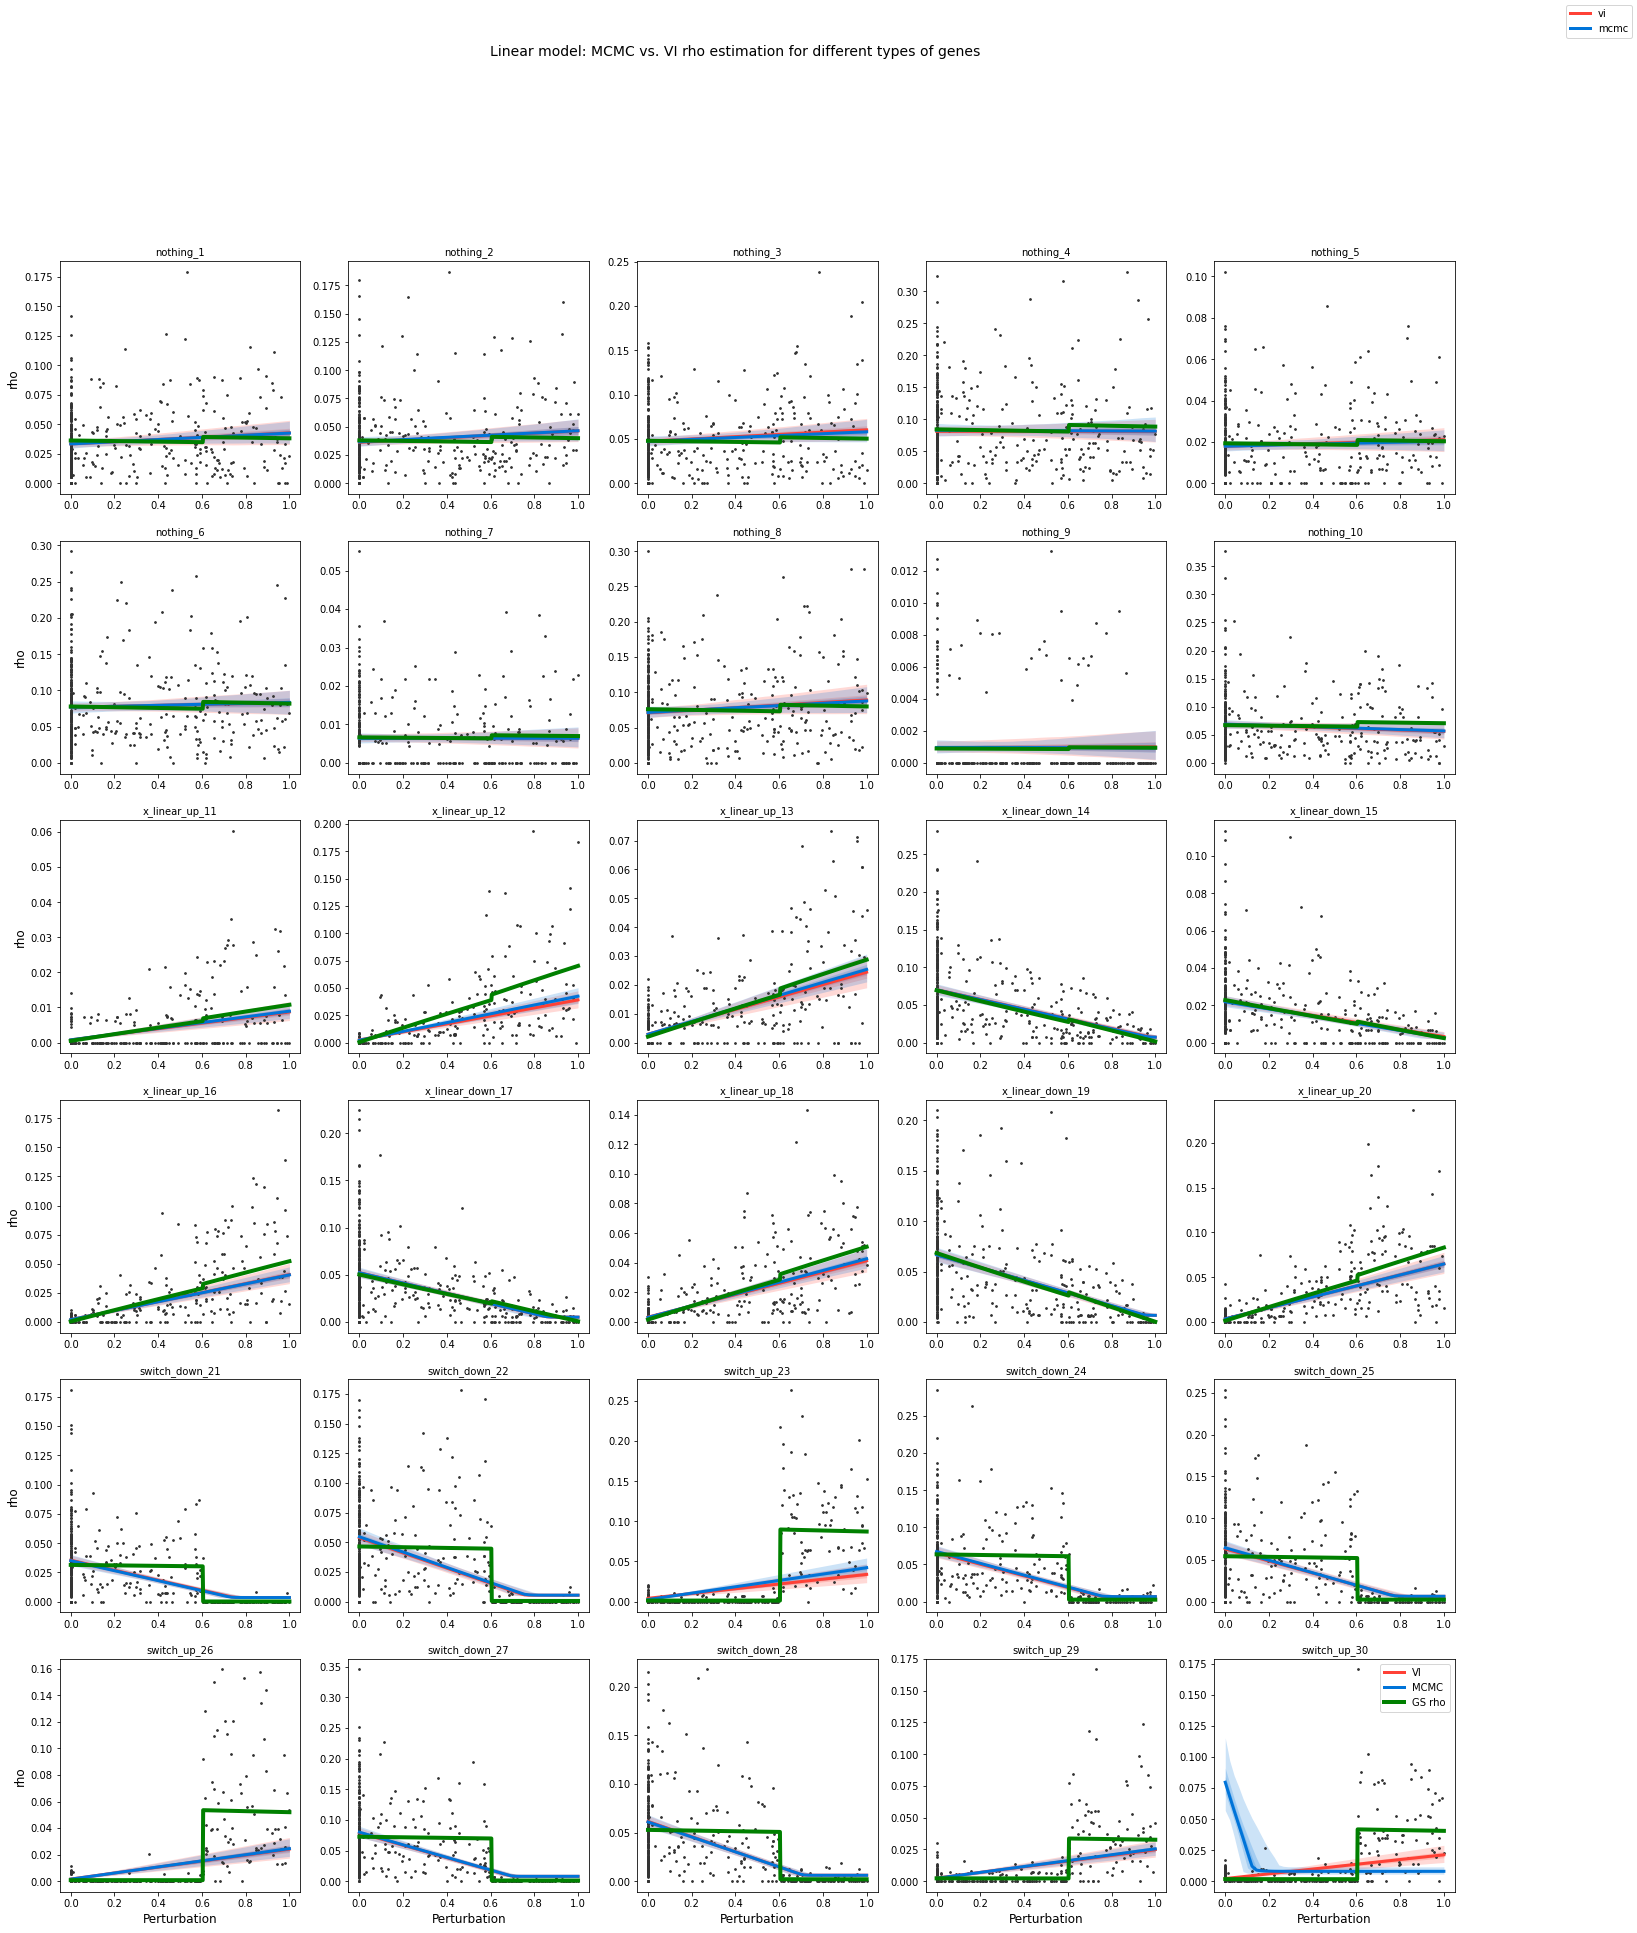

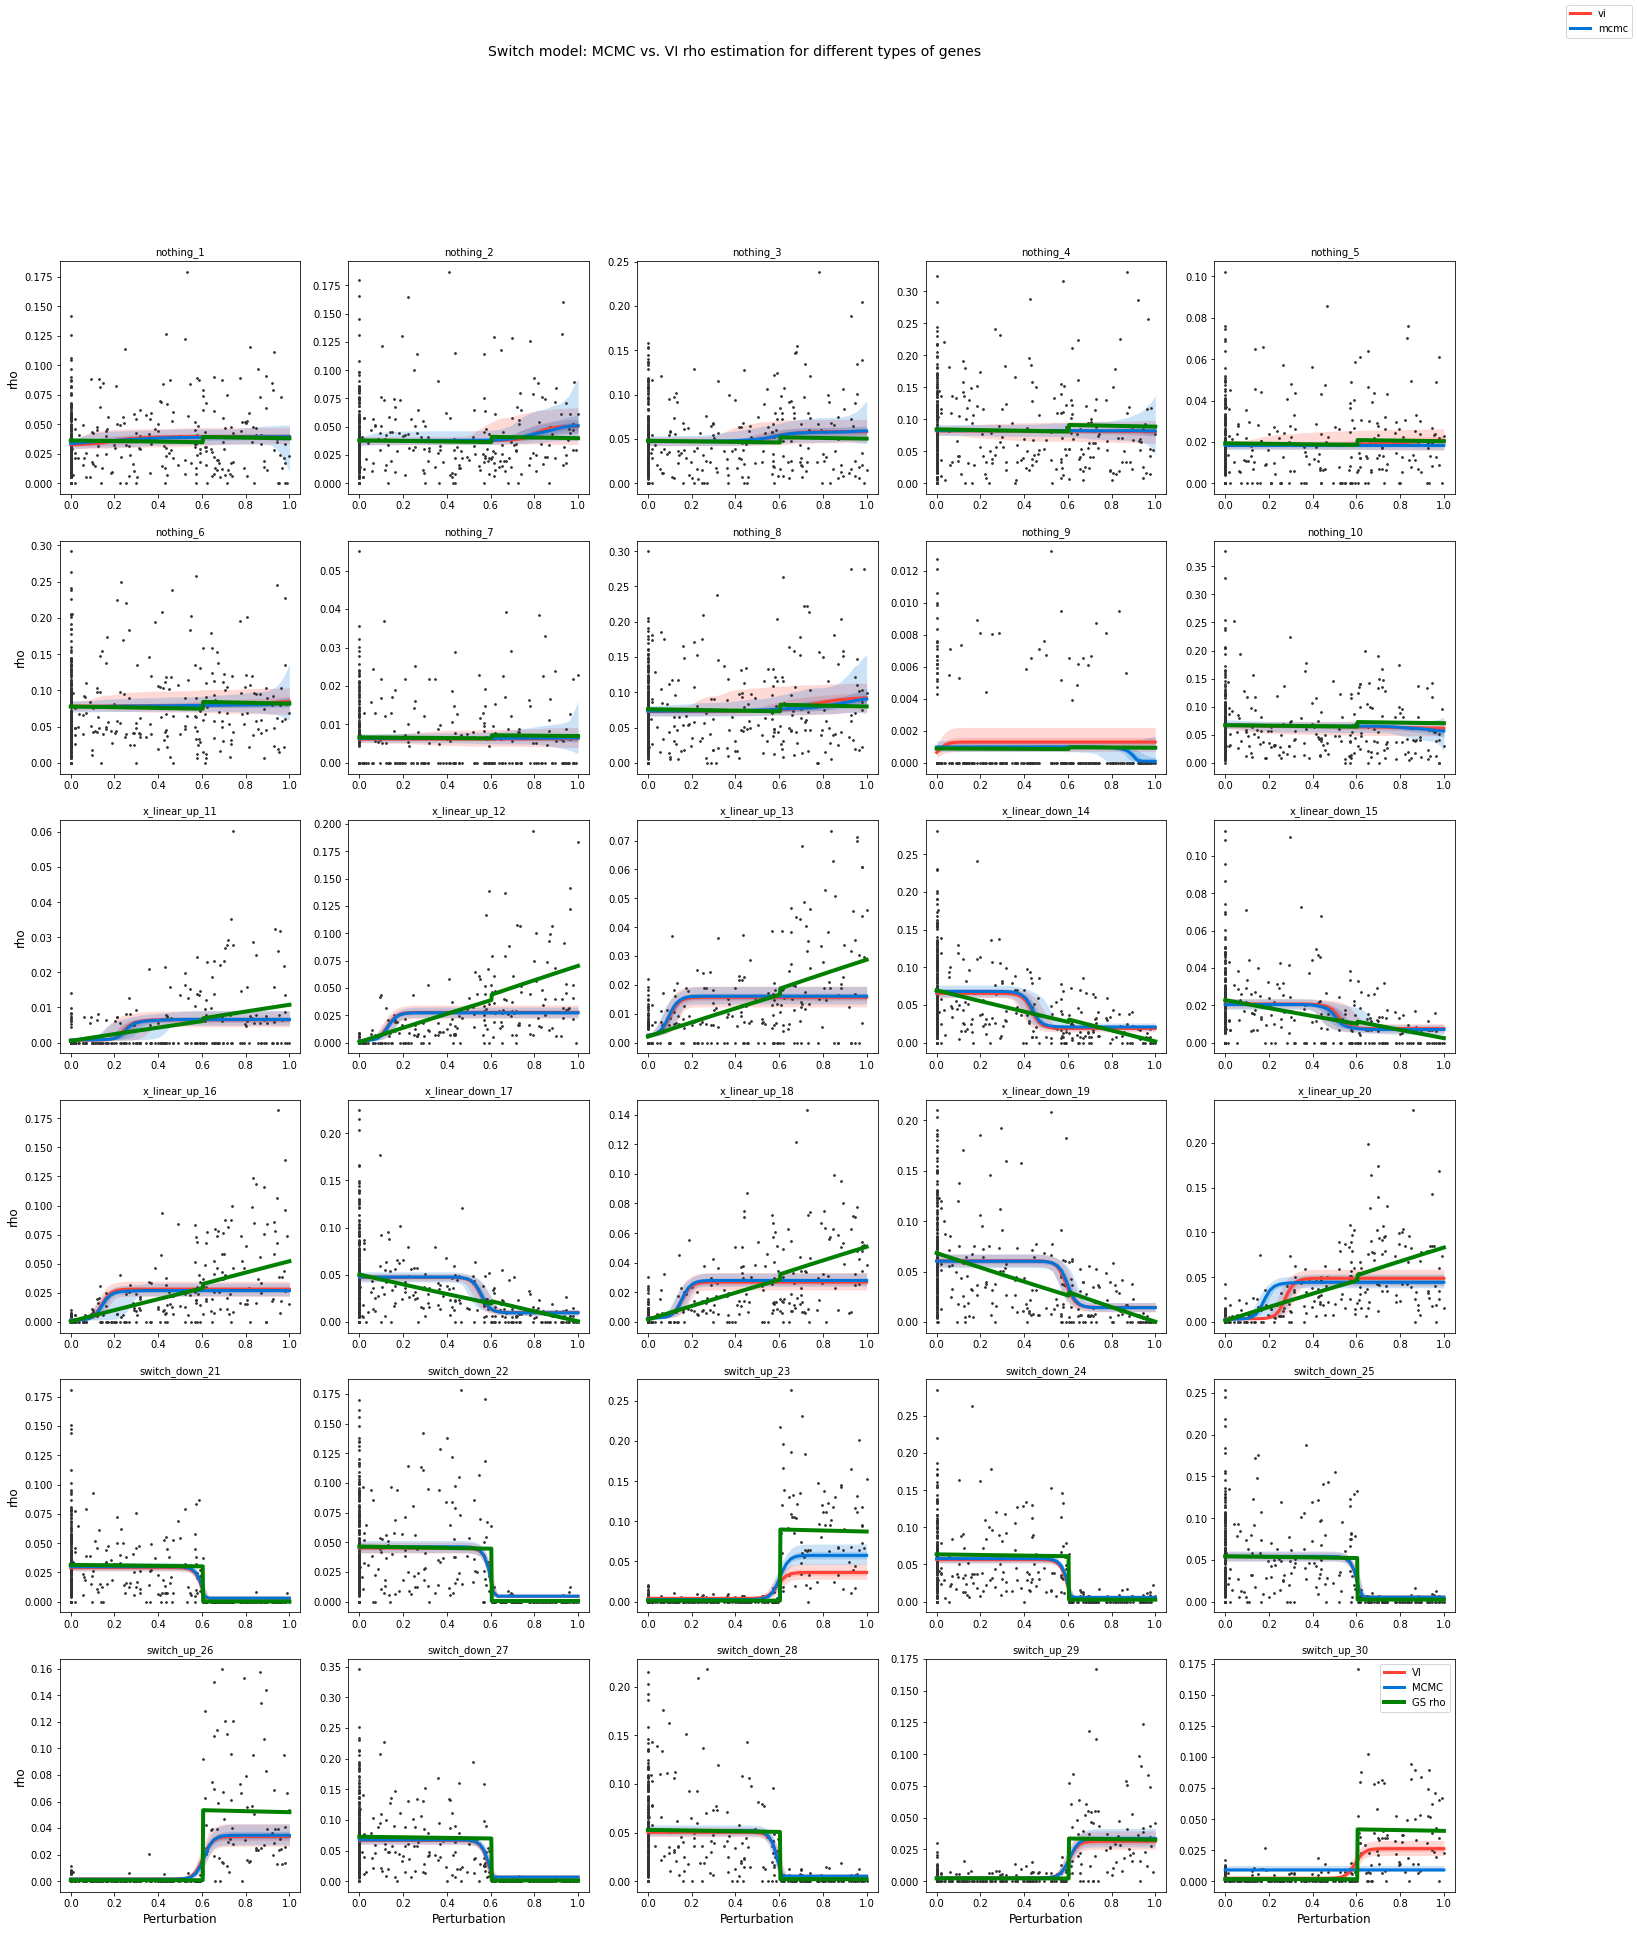

In [36]:
# Plot rho estimation for every model
models = [latento.models.ModelNothing(dataset),
          latento.models.ModelLinear(dataset),
          latento.models.ModelSwitch(dataset)]

for zip_ in zip(model_name, models, samples_mcmc, samples_vi):
  model_name_, model_, samples_mcmc_, samples_vi_ = zip_[0], zip_[1], zip_[2], zip_[3]
  plot_posteriors.rho_estimation(model_name_, model_, samples_mcmc_, samples_vi_, dataset, rng_key_, infer_args, save_path)

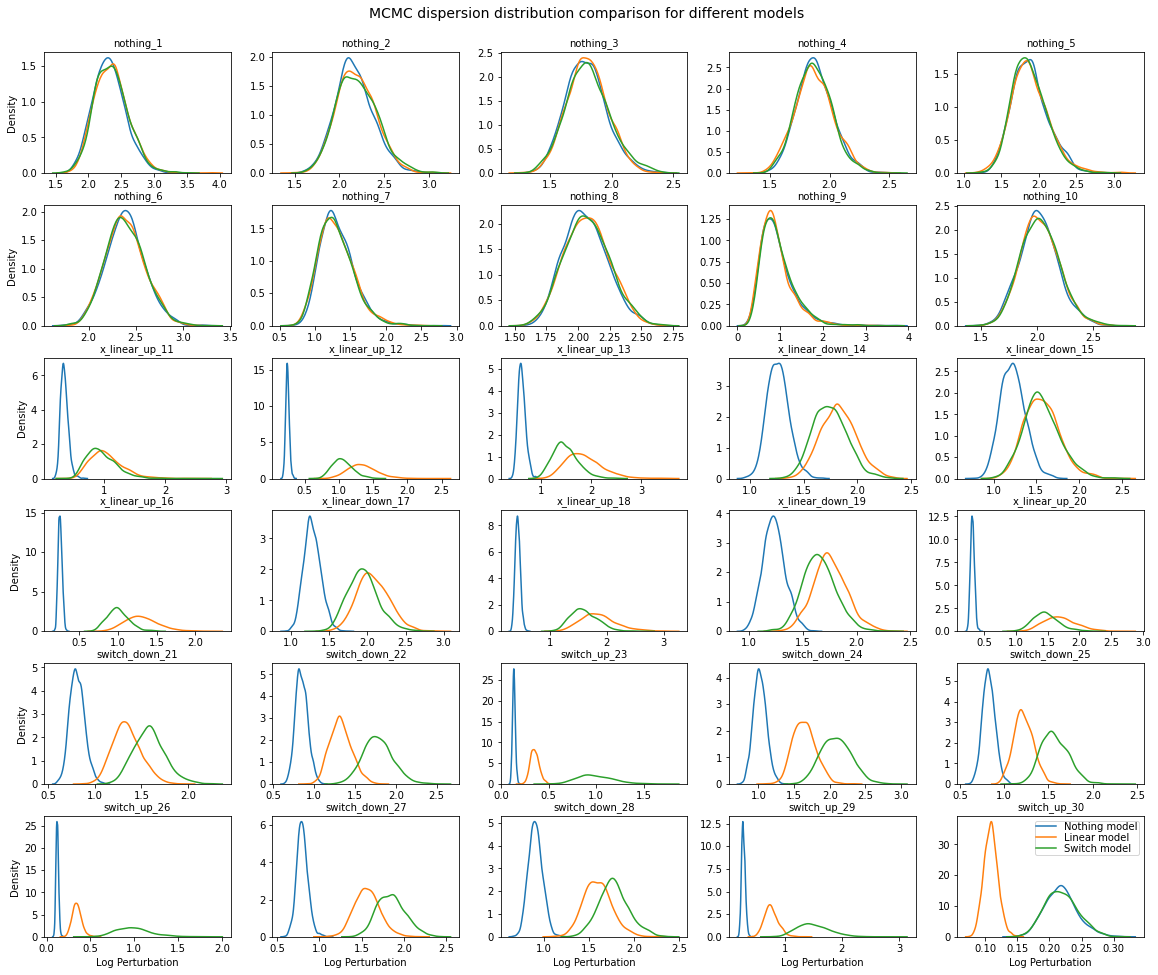

Figure saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/figures/set2/mcmc_all_models_dispersion.jpg


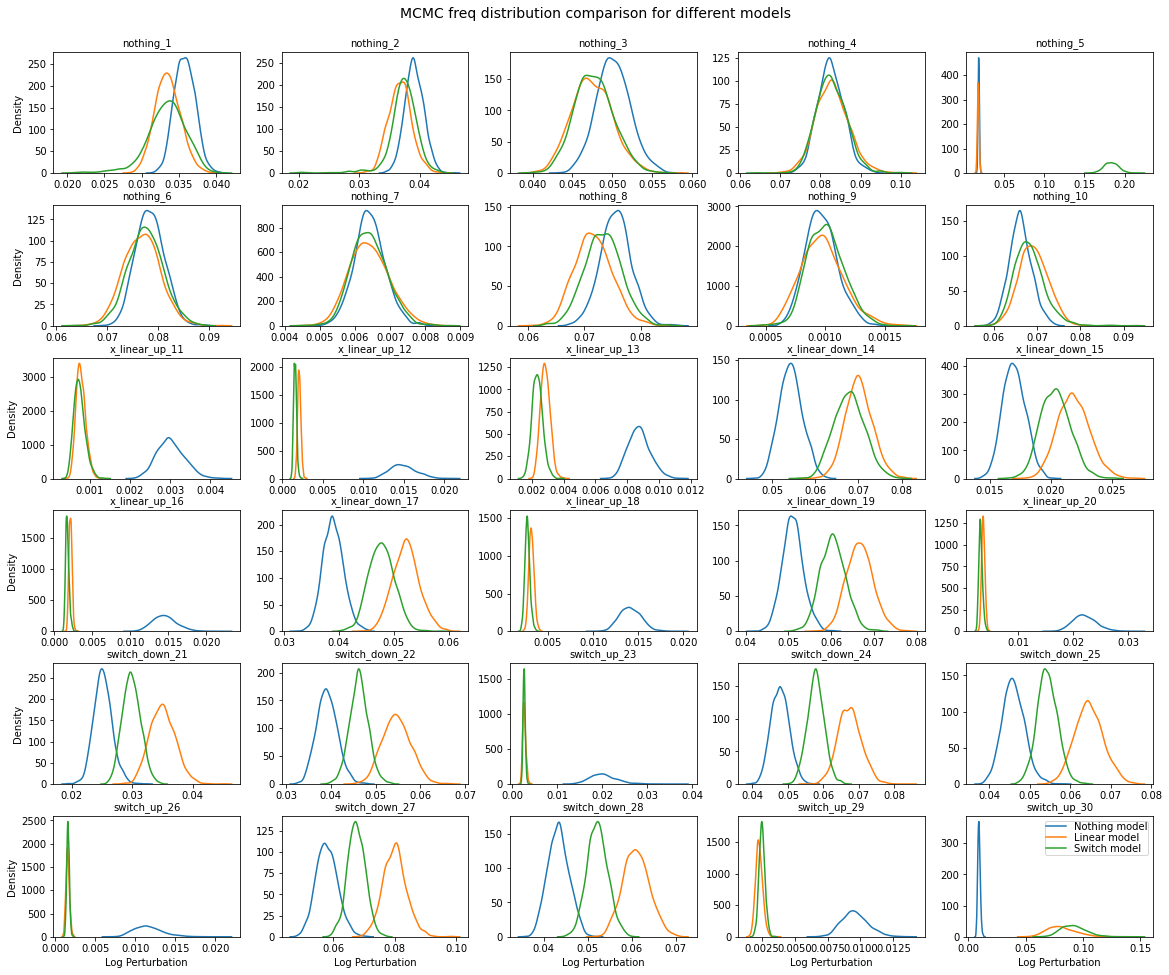

Figure saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/figures/set2/mcmc_all_models_freq.jpg


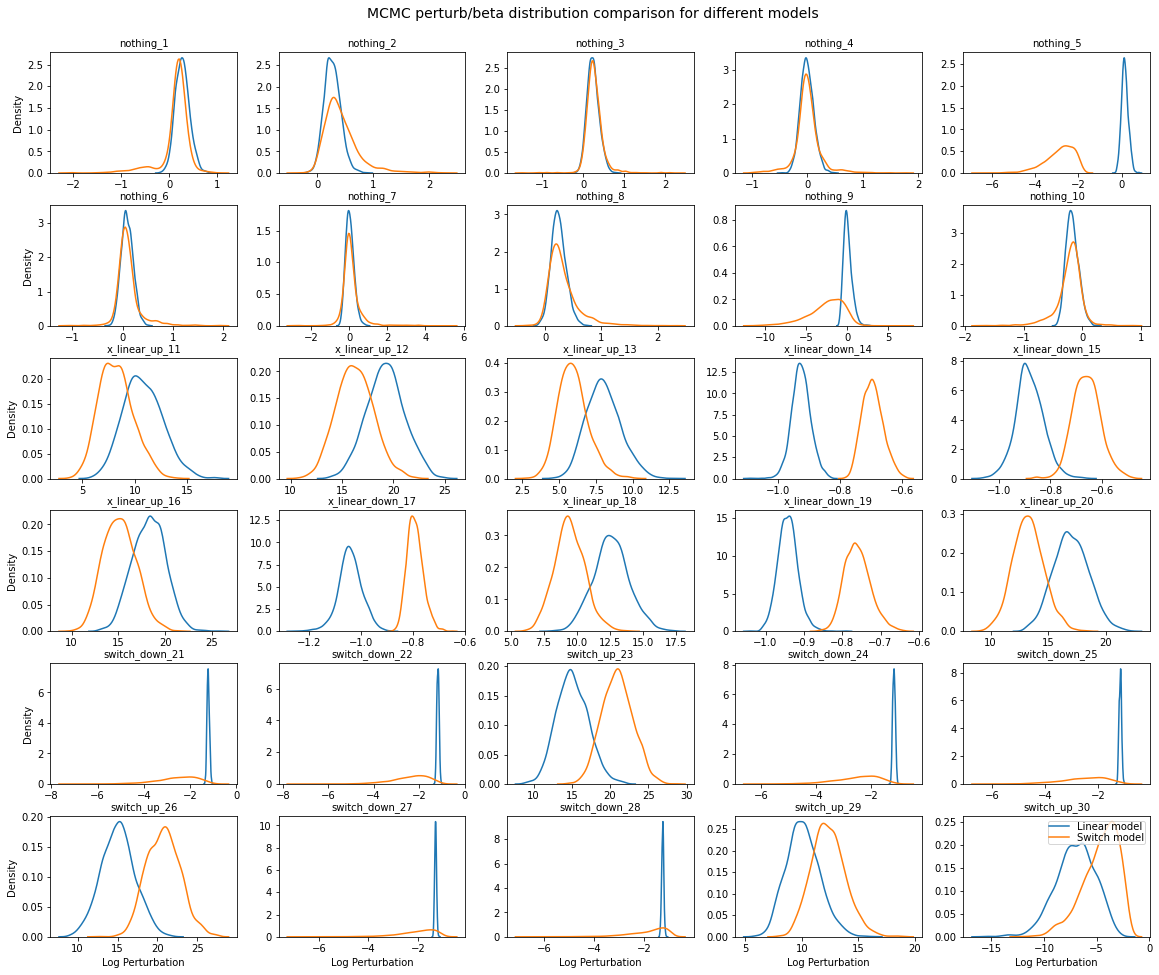

Figure saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/figures/set2/mcmc_all_models_perturb-beta.jpg


In [37]:
# SET 2 figures: Plot MCMC posteriors for different types of models

#---------------------- for MCMC --------------------|
#dispersion for every gene | nothing-linear-switch | 
#freq for every gene | nothing-linear-switch | 
#perturb/beta for every gene | linear-switch | 

save_path = f'{dir}/figures/set2'

samples_mcmc_list = [[samples_mcmc_nothing, 'Nothing model'],
                     [samples_mcmc_linear, 'Linear model'],
                     [samples_mcmc_switch, 'Switch model']]

dist_type = ['dispersion', 'freq', 'perturb/beta']

for dist in dist_type:
  if dist == 'perturb/beta':
    plot_posteriors.print_compare_models_MCMC(dist, samples_mcmc_list[1:], dataset, save_path)
  else:
    plot_posteriors.print_compare_models_MCMC(dist, samples_mcmc_list, dataset, save_path)

In [49]:
# Calculate Pearson correlation by comparing a set of distributions for a given model and gene

mcmc_models_dists = [[samples_mcmc_nothing, ['dispersion', 'freq'], 'Nothing model'],
                     [samples_mcmc_linear, ['dispersion', 'freq', 'perturb/beta'], 'Linear model'],
                     [samples_mcmc_switch, ['dispersion', 'freq', 'perturb/beta', 'switch'], 'Switch model']]

cor_threshold = 0.5
p_threshold = 0.05
save_path = f'{dir}/correlations/pearson_C_{cor_threshold}_p_{p_threshold}.txt'

str_log_list, total_combinations = estimate_posteriors.mcmc_pearson_correlation(mcmc_models_dists, dataset, cor_threshold, p_threshold, save_path)

for cor in str_log_list:
    print("%s\n" % cor)

Calculating Pearson correlation by comparing a set of distributions for a given model and gene:
cor_threshold=0.5 and p_threshold=0.05
Pearson correlations found: 43 out of 300 total combinations
Log file saved in dir: /content/gdrive/MyDrive/GC/ML_Project2/project-433/correlations/pearson_C_0.5_p_0.05.txt
Linear model, freq vs. perturb/beta, nothing_1: cor=-0.6503689991848683, p=7.377886545215124e-241

Linear model, freq vs. perturb/beta, nothing_2: cor=-0.6409605043632192, p=8.214080950919986e-232

Linear model, freq vs. perturb/beta, nothing_3: cor=-0.5907062718647704, p=1.9555558952733392e-188

Linear model, freq vs. perturb/beta, nothing_4: cor=-0.5954067230676194, p=3.602213141102897e-192

Linear model, freq vs. perturb/beta, nothing_5: cor=-0.6180719528872829, p=4.452472430804328e-211

Linear model, freq vs. perturb/beta, nothing_6: cor=-0.6324149988769717, p=7.251551825817286e-224

Linear model, freq vs. perturb/beta, nothing_7: cor=-0.6206774038156183, p=2.371167782525305e-213

**Your task**

- How does the "exact" posterior look like?
- Does VI provide a good approximation of the mean?
- Does VI provide a good approximation of the variance?
- Does the posterior has any weird features, such as multiple modes or long tails?
- Are there any dependencies within the posterior?

All of these questions you can answer for:

- Is this variable dependent? E.g. dispersion vs beta...
- Is this model dependent? E.g. the "nothing" vs "linear" model...
- Is this gene dependent? E.g. "nothing" genes vs "linear" genes..., check out `dataset.var["type"]` to get the type of a gene

### Comparing models

To compare models (e.g. a "nothing" model vs a "linear" model), we will check their "Posterior Predictive Density", which is essentially the likelihood of the observations based on the posterior distribution.

Note that this value does not account for overfitting, and complex models will typically have a higher posterior predictive density. We therefore have to use cross-validation (or, if there are latent variables, bayesian model selection). It's up to you to implement this.

In [ ]:
model_conditioned = numpyro.handlers.condition(numpyro.handlers.seed(model.forward, rng_key), {})
model_trace = numpyro.handlers.trace(model_conditioned).get_trace(**infer_args)
obs_node = model_trace['transcriptome']

In [ ]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model_conditioned = numpyro.handlers.condition(numpyro.handlers.seed(model, rng_key), params)
    model_trace = numpyro.handlers.trace(model_conditioned).get_trace(*args, **kwargs)
    obs_node = model_trace['transcriptome']
    return obs_node['fn'].base_dist.log_prob(obs_node['value']) # remove the event dimensions by using the base dist as we're interested in the log probability per gene

def log_pred_density(rng_key, samples, model, *args, **kwargs):
    n = list(samples.values())[0].shape[0]
    log_lk_fn = jax.vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(jax.random.split(rng_key, n), samples)
    return (jax.scipy.special.logsumexp(log_lk_vals, 0) - jnp.log(n))

In [ ]:
lpd = log_pred_density(rng_key, samples_mcmc, model.forward, **infer_args)

In [ ]:
lpd_gene = lpd.mean(0) # the mean log predictive density for a gene across all cells
lpd_gene

DeviceArray([-2.725937  , -2.7962787 , -2.9644647 , -3.5035512 ,
             -2.2399817 , -3.392265  , -1.4533625 , -3.3620374 ,
             -0.45817277, -3.295496  , -0.8435185 , -1.8937329 ,
             -1.588212  , -3.174781  , -2.1340961 , -1.7290673 ,
             -2.8618035 , -1.8671995 , -3.081276  , -2.1334066 ,
             -2.2426786 , -2.6731837 , -2.0725412 , -2.905181  ,
             -2.8017533 , -1.7164901 , -2.9579282 , -2.7482495 ,
             -1.8187214 , -1.7439204 ], dtype=float32)

**Your task**

- Compare the log predictive density for each gene for different models. Do they make sense? I.e. for genes that do not change with the perturbation, the lpd should be approximately the same for different models. For genes that have a linear pattern, the best model should be linear. Etc...
- Could we make some wrong conclusions if we use VI instead of getting an exact posterior using e.g. MCMC? Could we for example choose an incorrect model? Could we be overconfident?

Again...

- Is this dependent on the type of gene? (nothing, linear, switch, ...)